In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.ndimage import gaussian_filter1d

In [2]:
np.random.seed(5)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
x = [1,2,3,4,5]
y = slice(0,2)
x[y]

[1, 2]

In [4]:
'''
returns a inp_event_max ** inp_num, inp_num, inp_event_max shape matrix of all possible input events
This was made by chatgpt
'''

def generate_combinations(inp_num, inp_event_max):
    total_combinations = inp_event_max ** inp_num
    combinations = np.zeros((total_combinations, inp_event_max, inp_num), dtype=int)

    for i in range(total_combinations):
        temp = i
        for j in range(inp_num):
            index = temp % inp_event_max
            combinations[i, index,j] = 1
            temp = temp // inp_event_max

    return combinations

In [5]:
def calc_reps(T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, inp_delay_range, rec_delay_range,V_th):
        # Function to simulate a spiking neural network with recurrent connections and input events.

    # Some parameters are passed to the function:
    # T: Total duration of the simulation.
    # start_time: Starting time for input events.
    # end_time: Ending time for input events.
    # inp_num: Number of input neurons.
    # rec_num: Number of excitatory recurrent neurons.
    # inh_num: Number of inhibitory recurrent neurons.
    # inh_duration: Duration for which inhibitory neurons have an effect on excitatory neurons.
    # inp_delay_range: Range of input delays.
    # rec_delay_range: Range of recurrent delays.
    # V_th: Threshold voltage for spike generation.

    # Randomly generate input delays for each input neuron.
    # Randomly generate recurrent delays for all neurons.
    # Initialize arrays to store input and recurrent events.
    # Iterate through combinations of input events using a recursive loop.
    # Calculate the total number of recurrent spikes and the percentage of independent responses.

    # Return the simulated events, neuron labels, and statistics (total_spikes, pct_response).
    # (thanks chatgpt ^^^)
    
    inp_event_max = inp_delay_range[1]-inp_delay_range[0]

    inp_delays = np.random.randint(*inp_delay_range,(inp_num ,rec_num))
    rec_delays = np.random.randint(*rec_delay_range,(rec_num+inp_num+inh_num,rec_num+inp_num+inh_num))
    inp_delays.shape,rec_delays.shape
    all_input_events = np.zeros((inp_event_max**inp_num, T, inp_num))
    all_rec_events = np.zeros((inp_event_max**inp_num, T,rec_num))
    all_events = np.zeros((inp_event_max**inp_num,T,inp_num+rec_num+inh_num))
    

    '''
    this needs to be a recursive loop since we don't know how mnay inputs there will be!
    '''
    idc = 0
    curr_inp = 0
    all_input_events[:,start_time:start_time+inp_event_max,:] = generate_combinations(inp_num, inp_event_max)
    nrn_labels = np.array(inp_num*[0] + rec_num*[1] + inh_num*[2])
    
    rec_label=2
    
# all_input_events[-1,:,:]
    idc=0
    for inp_events in all_input_events:
        rec_events = np.zeros((T,rec_num+inh_num))
    #     inp = np.random.randint(0,10,(inp_num))
    #     inp_events = np.zeros((T,inp_num))
    #     for i in range(inp_num):
    #         inp_events[start_time+inp[i],i] =1
    #     inp_events.shape

        for t in range(1+start_time,end_time):
            for j in range(rec_num): # this for loop only iterates over excitatory recurrent neurons
                I = 0

                for i in range(inp_num):
                    I += inp_events[t-inp_delays[i,j],i]
                for i in range(rec_num+inh_num):
                    if i!=j:
                        I += rec_events[t-rec_delays[i,j],i]/2 # this offsets their label value

                if I>V_th:
                    rec_events[t,j] =2
                else:
                    rec_events[t,j] =0

            for j in range(rec_num,rec_num+inh_num): # this loop only iterates over inhbiitory recurrent neurons
                I = 0

                for i in range(rec_num):
                    if i!=j:
                        I += rec_events[t-rec_delays[i,j],i]


                if I>1:
                    rec_events[t,j] =-2
                else:
                    rec_events[t,j] =0

        events = np.zeros((T,inp_num+rec_num+inh_num))
        events[:,:inp_num] = inp_events
        events[:,inp_num:inp_num+rec_num+inh_num] = rec_events
        all_events[idc]=events
    #     all_rec_events[]
        idc+=1
        
        '''
        Do stats in the same method...?
        
        '''
        
        pct_response = 0 # pct of independent responses
    all_events_bin = np.zeros_like(all_events)
    all_events_bin[all_events != 0] = 1
    total_spikes = np.mean(np.sum(all_events_bin,axis=(1,2))-inp_num) # number of rec spikes for each trial    
    pct_response = ((inp_event_max ** inp_num - 
                    len(np.where(np.sum(all_events_bin,axis=(1,2))-inp_num == 0)[0])) / 
                    inp_event_max ** inp_num) # Pct of non-zero recurrent responses to input
    
    
    return all_events, nrn_labels, (total_spikes, pct_response)
    

# all_rec_events, evoked_spikes, temporal_depth,  unique_signatures = calc_reps(**params)

In [6]:

T = 100 # miliseconds of simulation time
start_time=10
end_time=90
inp_num = 2
rec_num = 4
inh_num = 2
nrns = np.array((inp_num*[0]+rec_num*[1]+inh_num*[2]))

inh_duration = 2
inp_delay_range=(1,5)
rec_delay_range=(1,5)
inp_event_max=4
V_th=1

default_params = {
    'T' : T, # miliseconds of simulation time
    'start_time':start_time,
    'end_time':end_time,
    'inp_num' : inp_num,
    'rec_num' : rec_num,
    'inh_num' : inh_num,
    'inh_duration' : inh_duration,
    'inp_delay_range':inp_delay_range,
    'rec_delay_range':rec_delay_range,
    'V_th':V_th
}

colors = np.array(['#1f77b4', '#1f77b4', '#1f77b4', '#d62728', '#d62728', '#d62728', '#d62728', '#d62728', '#d62728', '#17becf'])
colors = np.array(inp_num*['#1f77b4'] + rec_num*['#d62728'] + inh_num*['#17becf'])

In [7]:
trials = 1

all_events = np.zeros((trials, inp_event_max**inp_num,T,inp_num+rec_num+inh_num))

for trial in tqdm(range(trials)):
    all_events[trial],nrn_labels, stats = calc_reps(**default_params)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.36it/s]


In [8]:
stats

(4.875, 0.5)

In [9]:
all_events.shape, inp_num

((1, 16, 100, 8), 2)

# statistics!

In [10]:
scan_dict = {
    'inp_num':[2,3],
    'rec_num':[2,3,4,5,6,9,13,20],
    'inh_num':[1,2,3,4,8,12],
    'inh_duration':[1,2,3,4,5],
    'inp_delay_range':[(1,5),(1,6),(1,7),(1,8),(1,10),(1,15),(1,20)],
    'rec_delay_range':[(1,5),(1,6),(1,7),(1,10)],
    'V_th':[1,2,3,4,5]
}

In [11]:
T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, inp_delay_range, rec_delay_range,V_th = params.values()

NameError: name 'params' is not defined

In [12]:
# Import required libraries and functions (assuming they are already defined)
import pandas as pd
from tqdm import tqdm  # Import tqdm for the progress bar
import json
import os

# Simulation parameters
T = 100
start_time = 10
end_time = 90

# Initialize an empty list to store the results for each parameter combination
results_list = []

# Calculate the total number of parameter combinations
total_combinations = (len(scan_dict['inp_num']) *
                     len(scan_dict['rec_num']) *
                     len(scan_dict['inh_num']) *
                     len(scan_dict['inh_duration']) *
                     len(scan_dict['inp_delay_range']) *
                     len(scan_dict['rec_delay_range']) *
                     len(scan_dict['V_th']))

# Checkpoint file name
checkpoint_file = 'parameter_search_checkpoint.json'

# Check if the checkpoint file exists and load the progress if it does
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'r') as f:
        checkpoint_data = json.load(f)
    idx = checkpoint_data['idx']
    results_list = checkpoint_data['results_list']
else:
    idx = 0

# Perform the parameter sweep
for inp_num in scan_dict['inp_num']:
    for rec_num in scan_dict['rec_num']:
        for inh_num in scan_dict['inh_num']:
            for inh_duration in scan_dict['inh_duration']:
                for inp_delay_range in scan_dict['inp_delay_range']:
                    for rec_delay_range in scan_dict['rec_delay_range']:
                        for V_th in scan_dict['V_th']:
                            # Create a new set of parameters for each combination
                            params = {
                                'T': T,
                                'start_time': start_time,
                                'end_time': end_time,
                                'inp_num': inp_num,
                                'rec_num': rec_num,
                                'inh_num': inh_num,
                                'inh_duration': inh_duration,
                                'inp_delay_range': inp_delay_range,
                                'rec_delay_range': rec_delay_range,
                                'V_th': V_th
                            }

                            trials = 1  # You can change the number of trials here if needed
                            T, start_time, end_time, inp_num, rec_num, inh_num, inh_duration, inp_delay_range, rec_delay_range,V_th = params.values()                            
                            inp_event_max = inp_delay_range[1] - inp_delay_range[0]
                            all_events = np.zeros((trials, inp_event_max**inp_num, T, inp_num + rec_num + inh_num))

                            for trial in range(trials):
                                all_events[trial], nrn_labels, stats = calc_reps(**params)

                            # Process the simulation results or save them for later analysis
                            # For example, you can calculate statistics and store them in a dictionary
                            # for each parameter combination

                            # Calculate statistics
                            total_spikes, pct_response = stats
                            avg_total_spikes = np.mean(total_spikes)
                            avg_pct_response = np.mean(pct_response)

                            # Create a dictionary to store the results for the current parameter combination
                            result_dict = {
                                'inp_num': inp_num,
                                'rec_num': rec_num,
                                'inh_num': inh_num,
                                'inh_duration': inh_duration,
                                'inp_delay_range': inp_delay_range,
                                'rec_delay_range': rec_delay_range,
                                'V_th': V_th,
                                'avg_total_spikes': avg_total_spikes,
                                'avg_pct_response': avg_pct_response
                            }

                            # Append the dictionary to the results list
                            results_list.append(result_dict)

                            # Update the progress bar for parameter combinations
#                             param_combinations.update(1)

                            # Append the dictionary to the results list
                            results_list.append(result_dict)

                            progress = idx  / total_combinations

                            # Print the progress directly to the screen
                            print(f'\rParameter Combinations: {idx}/{total_combinations} ({progress:.2%})', end='')
                    
                            # Save checkpoint every 1000 iterations (you can adjust this as needed)
                            if idx % 1000 == 0:
                                checkpoint_data = {
                                    'idx': idx,
                                    'results_list': results_list
                                }
                                with open(checkpoint_file, 'w') as f:
                                    json.dump(checkpoint_data, f)

                            idx += 1


# Close the progress bar for parameter combinations
print()

# Save the final results to the checkpoint file
checkpoint_data = {
    'idx': idx,
    'results_list': results_list
}
with open(checkpoint_file, 'w') as f:
    json.dump(checkpoint_data, f)

# Create a pandas DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

# Now, you have a DataFrame (results_df) containing the results for all parameter combinations
# You can save it to a CSV file or further analyze and visualize the data as needed


Parameter Combinations: 72683/67200 (108.16%)Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\miles\AppData\Local\Temp\ipykernel_8664\3016757613.py", line 64, in <module>
    all_events[trial], nrn_labels, stats = calc_reps(**params)
                                           ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\miles\AppData\Local\Temp\ipykernel_8664\1003776666.py", line -1, in calc_reps
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\IPython\core\interactiveshell.py", line 2102, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\miles\anaconda3\envs\mysnn\Lib\site-packages\IPython\core\ultratb.py", line 1310, in structured_traceback
   

In [13]:
results_df = pd.DataFrame(results_list)

In [14]:
results_df

,inp_num,rec_num,inh_num,inh_duration,inp_delay_range,rec_delay_range,V_th,avg_total_spikes,avg_pct_response
0,2,2,1,1,"[1, 5]","[1, 5]",1,1.0,0.375
1,2,2,1,1,"[1, 5]","[1, 5]",1,1.0,0.375
2,2,2,1,1,"[1, 5]","[1, 5]",2,0.0,0.000
3,2,2,1,1,"[1, 5]","[1, 5]",2,0.0,0.000
4,2,2,1,1,"[1, 5]","[1, 5]",3,0.0,0.000
...,...,...,...,...,...,...,...,...,...
145369,2,13,4,3,"(1, 15)","(1, 5)",2,0.0,0.000
145370,2,13,4,3,"(1, 15)","(1, 5)",3,0.0,0.000
145371,2,13,4,3,"(1, 15)","(1, 5)",3,0.0,0.000
145372,2,13,4,3,"(1, 15)","(1, 5)",4,0.0,0.000


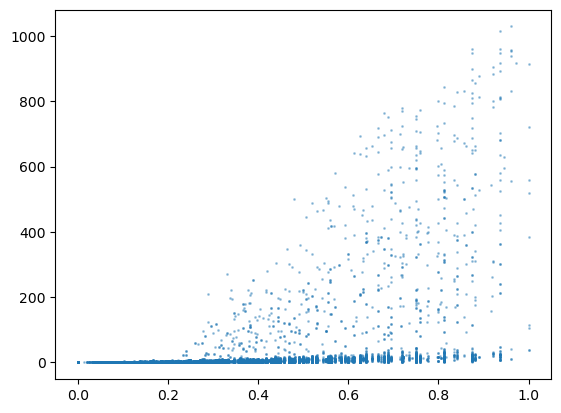

In [46]:
test_num_spikes = np.array(results_df['avg_total_spikes'])
test_avg_pct_response = np.array(results_df['avg_pct_response'])
plt.figure()
plt.scatter(test_avg_pct_response,test_num_spikes,s=1,alpha=0.2)
plt.show()

In [26]:
good_results = results_df[results_df['avg_pct_response']>=0.9]

In [27]:
len(good_results)

186

In [28]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [29]:
good_results

,inp_num,rec_num,inh_num,inh_duration,inp_delay_range,rec_delay_range,V_th,avg_total_spikes,avg_pct_response
38380,2,6,4,3,"[1, 5]","[1, 7]",1,6.125000,0.937500
38381,2,6,4,3,"[1, 5]","[1, 7]",1,6.125000,0.937500
82004,2,9,1,1,"[1, 5]","[1, 5]",1,362.062500,0.937500
82005,2,9,1,1,"[1, 5]","[1, 5]",1,362.062500,0.937500
82034,2,9,1,1,"[1, 5]","[1, 10]",1,6.750000,0.937500
82035,2,9,1,1,"[1, 5]","[1, 10]",1,6.750000,0.937500
82284,2,9,1,2,"[1, 5]","[1, 5]",1,303.000000,0.937500
82285,2,9,1,2,"[1, 5]","[1, 5]",1,303.000000,0.937500
83404,2,9,2,1,"[1, 5]","[1, 5]",1,213.312500,0.937500
83405,2,9,2,1,"[1, 5]","[1, 5]",1,213.312500,0.937500


In [38]:
params

{'T': 100,
 'start_time': 10,
 'end_time': 90,
 'inp_num': 2,
 'rec_num': 2,
 'inh_num': 1,
 'inh_duration': 1,
 'inp_delay_range': (1, 6),
 'rec_delay_range': (1, 5),
 'V_th': 1}

Parameter Combinations: 20it [00:12, 137.52it/s]

In [321]:
len(scan_dict['inp_num'])

2

In [382]:
trials = 3
np.random.seed(5)

events_dict = {}
labels_dict = {}
stats_dict = {}
for key_idc, key in enumerate(scan_dict):
    
    events_dict[key] = {}
    labels_dict[key] = {}
    stats_dict[key] = {}
    
    for val_idc, val in enumerate(scan_dict[key]):
        
        
        
        params = default_params.copy()
        params[key]=val
        

        all_events = []
        stats = []
        np.zeros((trials, inp_event_max**inp_num,T,inp_num+rec_num+inh_num))

        for trial in tqdm(range(trials)):
            x, nrn_labels, stats_ = calc_reps(**params)
            all_events.append(x)
            stats.append(stats_)
        
        all_events = np.array(all_events)
        stats = np.array(stats)
        events_dict[key][val] = all_events
        labels_dict[key][val] = nrn_labels
        stats_dict[key][val] = stats


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.87it/s]


In [396]:
mean_spikes = []
std_spikes = []
mean_pct_indep = []
std_pct_indep = []
xlabels = []
for k in stats_dict['inp_delay_range'].keys():
    mean_spikes.append(np.mean(stats_dict['inp_delay_range'][k],axis=0)[0])
    std_spikes.append(np.std(stats_dict['inp_delay_range'][k],axis=0)[0])
    xlabels.append(k)
    mean_pct_indep.append(np.mean(stats_dict['inp_delay_range'][k],axis=0)[1])
    std_pct_indep.append(np.std(stats_dict['inp_delay_range'][k],axis=0)[1])
    
    
xlabels

[(1, 5), (1, 6), (1, 7), (1, 8), (1, 10), (1, 15), (1, 20)]

In [397]:
stats_dict['inp_delay_range'][k]

array([[0.44875346, 0.14958449],
       [0.44875346, 0.11357341],
       [0.4432133 , 0.12188366]])

In [393]:
np.mean(stats_dict['inp_delay_range'][k],axis=0)[0]

0.4469067405355494

In [398]:
mean_spikes

[3.3541666666666665,
 1.8666666666666665,
 1.4907407407407405,
 1.965986394557823,
 1.2386831275720167,
 0.5816326530612245,
 0.4469067405355494]

In [399]:
mean_spikes, std_spikes

([3.3541666666666665,
  1.8666666666666665,
  1.4907407407407405,
  1.965986394557823,
  1.2386831275720167,
  0.5816326530612245,
  0.4469067405355494],
 [1.1346040670158417,
  0.4622649552895924,
  0.48076870317582104,
  0.29870065850476407,
  0.18705050497717718,
  0.2164612595469023,
  0.0026116593949641657])

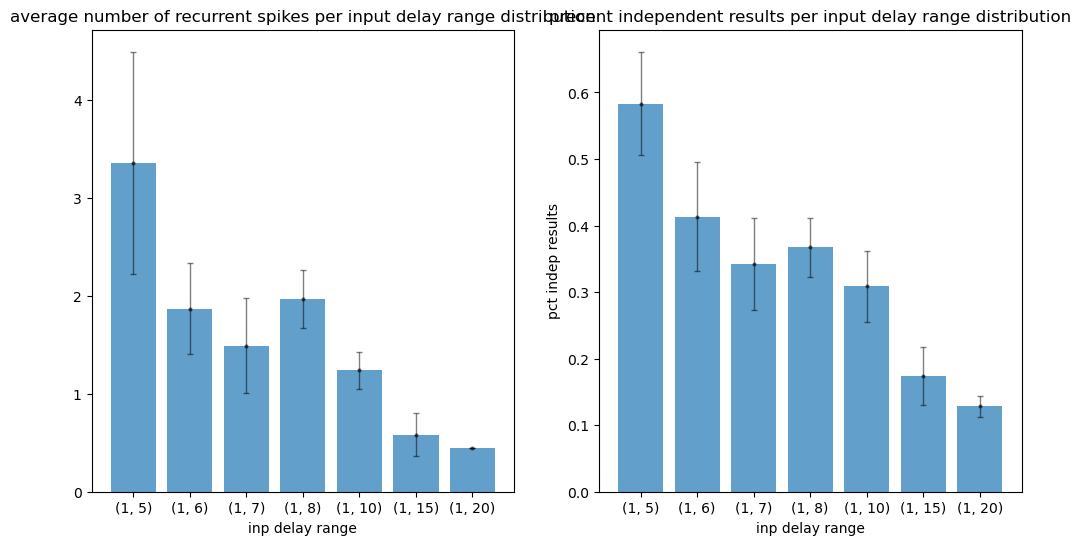

In [412]:
fig,ax = plt.subplot_mosaic('AB',figsize=(12,6))

a = np.arange(0,len(mean_spikes))

yerr=std_spikes
ax['A'].bar(a,mean_spikes,alpha=0.7)
ax['A'].errorbar(a,mean_spikes, yerr, fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax['A'].set_xticks(a,labels=xlabels)
ax['A'].set_xlabel('inp delay range')
ax['B'].set_ylabel('ave num rec spikes')
ax['A'].set_title('average number of recurrent spikes per input delay range distribution')

yerr=std_pct_indep
b = np.arange(0,len(mean_pct_indep))
ax['B'].bar(b,mean_pct_indep,alpha=0.7)
ax['B'].errorbar(a,mean_pct_indep, yerr, fmt='.', color='Black', elinewidth=1,capthick=1,errorevery=1, alpha=0.5, ms=4, capsize = 2)
ax['B'].set_xticks(b,labels=xlabels)
ax['B'].set_xlabel('inp delay range')
ax['B'].set_ylabel('pct indep results')
ax['B'].set_title('precent independent results per input delay range distribution')

plt.show()

In [183]:
events_dict.keys()

dict_keys(['inp_num', 'rec_num', 'inh_num', 'inh_duration', 'inp_delay_range', 'rec_delay_range', 'V_th'])

In [195]:
events_dict['inp_num'][2][0].shape, nrn_labels.shape

((1, 16, 100, 8), (8,))

In [210]:
nrn_labels

array([0, 0, 0, 1, 1, 1, 1, 2, 2])

In [211]:
colors = np.array(['#1f77b4', '#d62728', '#17becf'])
colors[nrn_labels]

array(['#1f77b4', '#1f77b4', '#1f77b4', '#d62728', '#d62728', '#d62728',
       '#d62728', '#17becf', '#17becf'], dtype='<U7')

In [213]:
np.where(current_events[i,...])[1]

array([1, 2, 0, 4, 6, 3, 4, 5, 7, 8, 7], dtype=int64)

In [269]:
list(events_dict[key].keys())

[0, 1, 2, 3, 4, 8, 12]

[0 0 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2]
(16, 100, 18)


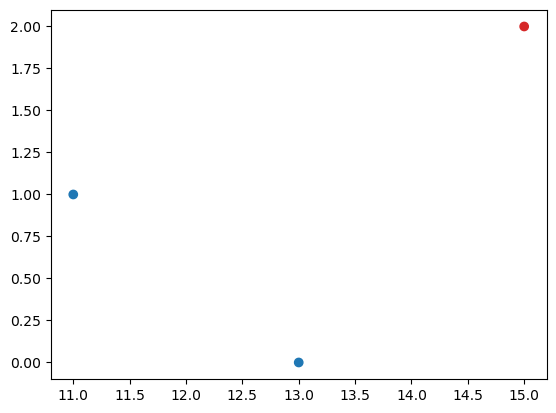

In [274]:
key = 'inh_num'
values = list(events_dict[key].keys())
val = values[-1]
current_events = events_dict[key][val][0][0,...]
nrn_labels = events_dict[key][val][1]
print(nrn_labels)
colors = np.array(['#1f77b4', '#d62728', '#17becf'])
colors = colors[nrn_labels]
print(current_events.shape)
plt.figure()
i=7
plt.scatter(np.where(current_events[i,...])[0],np.where(current_events[i,...])[1],c=colors[np.where(current_events[i,...])[1]])
plt.show()

In [181]:
current_events[i,...]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., 